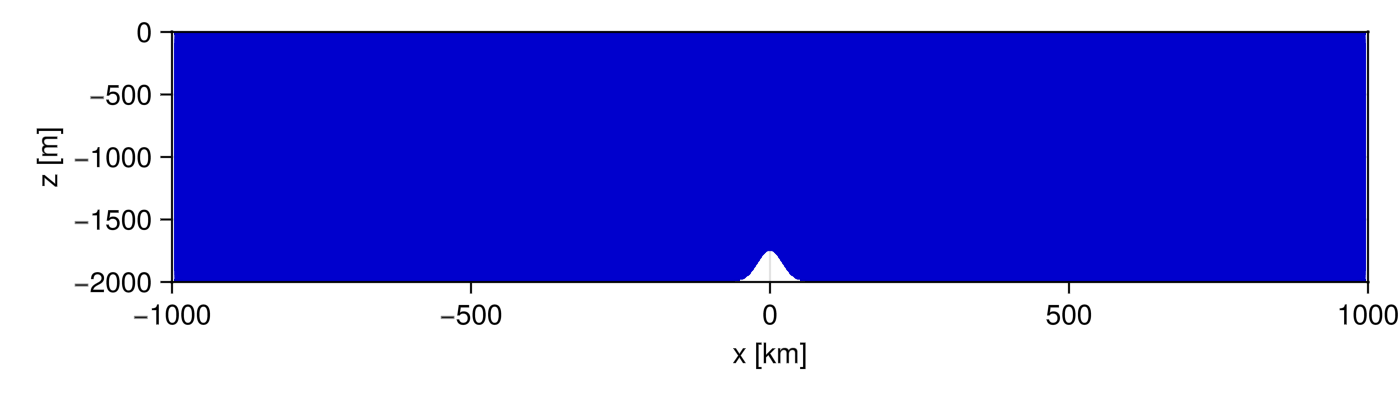

In [2]:
using Oceananigans
using Oceananigans.Units
using GLMakie

Nx = 256
Nz = 128
H = 2kilometers

underlying_grid = RectilinearGrid(size = (Nx, Nz),
                                  x = (-1000kilometers, 1000kilometers),
                                  z = (-H, 0),
                                  halo = (4, 4),
                                  topology = (Periodic, Flat, Bounded))

h₀ = 250meters
width = 20kilometers
hill(x) = h₀ * exp(-x^2 / 2width^2)
bottom(x) = - H + hill(x)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bottom))

# Let's see how the domain with the bathymetry is.

x = xnodes(grid, Center())
bottom_boundary = interior(grid.immersed_boundary.bottom_height, :, 1, 1)
top_boundary = 0*x

fig = Figure(size = (700, 200))
ax = Axis(fig[1, 1],
          xlabel = "x [km]",
          ylabel = "z [m]",
          limits = ((-grid.Lx/2e3, grid.Lx/2e3), (-grid.Lz, 0)))

band!(ax, x/1e3, bottom_boundary, top_boundary, color = :mediumblue)

fig

In [3]:
coriolis = FPlane(latitude = -45)

T₂ = 12.421hours
ω₂ = 2π / T₂ # radians/sec
ϵ = 0.1
U_tide = ϵ * ω₂ * width

F_tide = U_tide * (ω₂^2 - coriolis.f^2) / ω₂

@inline tidal_forcing(x, z, t, p) = p.F_tide * sin(p.ω₂ * t)

u_forcing = Forcing(tidal_forcing, parameters=(; F_tide, ω₂))

model = HydrostaticFreeSurfaceModel(; grid, coriolis,
                                      buoyancy = BuoyancyTracer(),
                                      tracers = :b,
                                      momentum_advection = WENO(),
                                      tracer_advection = WENO(),
                                      forcing = (; u = u_forcing))


uᵢ(x, z) = U_tide

Nᵢ² = 1e-4 # [s⁻²] initial buoyancy frequency / stratification
bᵢ(x, z) = Nᵢ² * z

set!(model, u=uᵢ, b=bᵢ)

Δt = 5minutes
stop_time = 4days

simulation = Simulation(model; Δt, stop_time)

# We add a callback to print a message about how the simulation is going,

using Printf

wall_clock = Ref(time_ns())

function progress(sim)
    elapsed = 1e-9 * (time_ns() - wall_clock[])

    msg = @sprintf("iteration: %d, time: %s, wall time: %s, max|w|: %6.3e, m s⁻¹\n",
                   iteration(sim), prettytime(sim), prettytime(elapsed),
                   maximum(abs, sim.model.velocities.w))

    wall_clock[] = time_ns()

    @info msg

    return nothing
end

add_callback!(simulation, progress, name=:progress, IterationInterval(200))
nothing #hide

# ## Diagnostics/Output

# Add some diagnostics. Instead of ``u`` we save the deviation of ``u`` from its instantaneous
# domain average, ``u' = u - (L_x H)^{-1} \int u \, \mathrm{d}x \mathrm{d}z``. We also save
# the stratification ``N^2 = \partial_z b``.

b = model.tracers.b
u, v, w = model.velocities

U = Field(Average(u))

u′ = u - U

N² = ∂z(b)

filename = "internal_tide"
save_fields_interval = 30minutes

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; u, u′, w, b, N²);
                                                      filename,
                                                      schedule = TimeInterval(save_fields_interval),
                                                      overwrite_existing = true)

# We are ready -- let's run!

run!(simulation)


[ Info: Initializing simulation...
[ Info: iteration: 0, time: 0 seconds, wall time: 1.258 minutes, max|w|: 2.248e-03, m s⁻¹
[ Info:     ... simulation initialization complete (9.115 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (24.903 seconds).
[ Info: iteration: 200, time: 16.667 hours, wall time: 41.796 seconds, max|w|: 5.189e-03, m s⁻¹
[ Info: iteration: 400, time: 1.389 days, wall time: 9.421 seconds, max|w|: 5.056e-03, m s⁻¹
[ Info: iteration: 600, time: 2.083 days, wall time: 9.439 seconds, max|w|: 1.989e-03, m s⁻¹
[ Info: iteration: 800, time: 2.778 days, wall time: 9.594 seconds, max|w|: 4.545e-03, m s⁻¹
[ Info: iteration: 1000, time: 3.472 days, wall time: 9.202 seconds, max|w|: 3.808e-03, m s⁻¹
[ Info: Simulation is stopping after running for 1.475 minutes.
[ Info: Simulation time 4 days equals or exceeds stop time 4 days.
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
ERROR: LoadError: MethodError: no met

LoadError: Failed to precompile CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] to "/Users/gregorywagner/.julia/compiled/v1.10/CairoMakie/jl_EZUVb3".

In [ ]:
# ## Load output

# First, we load the saved velocities and stratification output as `FieldTimeSeries`es.

saved_output_filename = filename * ".jld2"

u′_t = FieldTimeSeries(saved_output_filename, "u′")
 w_t = FieldTimeSeries(saved_output_filename, "w")
N²_t = FieldTimeSeries(saved_output_filename, "N²")

umax = maximum(abs, u′_t[end])
wmax = maximum(abs, w_t[end])

times = u′_t.times
nothing #hide

# For visualization purposes, we mask the region below the bathymetry with NaNs.

using Oceananigans.ImmersedBoundaries: mask_immersed_field!

for φ_t in (u′_t, w_t, N²_t), n in 1:length(times)
    mask_immersed_field!(φ_t[n], NaN)
end

# We retrieve each field's coordinates and convert from meters to kilometers.

xu,  yu,  zu  = nodes(u′_t[1]) ./ 1e3
xw,  yw,  zw  = nodes(w_t[1])  ./ 1e3
xN², yN², zN² = nodes(N²_t[1]) ./ 1e3
nothing #hide

# ## Visualize

# Now we can visualize our resutls! We use `CairoMakie` here. On a system with OpenGL
# `using GLMakie` is more convenient as figures will be displayed on the screen.
#
# We use Makie's `Observable` to animate the data. To dive into how `Observable`s work we
# refer to [Makie.jl's Documentation](https://makie.juliaplots.org/stable/documentation/nodes/index.html).

using CairoMakie

n = Observable(1)

title = @lift @sprintf("t = %1.2f days = %1.2f T₂",
                       round(times[$n] / day, digits=2) , round(times[$n] / T₂, digits=2))

u′ₙ = @lift interior(u′_t[$n], :, 1, :)
 wₙ = @lift interior( w_t[$n], :, 1, :)
N²ₙ = @lift interior(N²_t[$n], :, 1, :)

axis_kwargs = (xlabel = "x [km]",
               ylabel = "z [km]",
               limits = ((-grid.Lx/2e3, grid.Lx/2e3), (-grid.Lz/1e3, 0)), # note conversion to kilometers
               titlesize = 20)

fig = Figure(size = (700, 900))

fig[1, :] = Label(fig, title, fontsize=24, tellwidth=false)

ax_u = Axis(fig[2, 1]; title = "u'-velocity", axis_kwargs...)
hm_u = heatmap!(ax_u, xu, zu, u′ₙ; colorrange = (-umax, umax), colormap = :balance)
Colorbar(fig[2, 2], hm_u, label = "m s⁻¹")

ax_w = Axis(fig[3, 1]; title = "w-velocity", axis_kwargs...)
hm_w = heatmap!(ax_w, xw, zw, wₙ; colorrange = (-wmax, wmax), colormap = :balance)
Colorbar(fig[3, 2], hm_w, label = "m s⁻¹")

ax_N² = Axis(fig[4, 1]; title = "stratification N²", axis_kwargs...)
hm_N² = heatmap!(ax_N², xN², zN², N²ₙ; colorrange = (0.9Nᵢ², 1.1Nᵢ²), colormap = :thermal)
Colorbar(fig[4, 2], hm_N², label = "s⁻²")

fig

# Finally, we can record a movie.

@info "Making an animation from saved data..."

frames = 1:length(times)

record(fig, filename * ".mp4", frames, framerate=16) do i
    @info string("Plotting frame ", i, " of ", frames[end])
    n[] = i
end
nothing #hide

# ![](internal_tide.mp4)